<a href="https://colab.research.google.com/github/poko251/simple-autoencoder/blob/main/autoencoder_michal_sroka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modułów


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np


Funckja szumu gauusa


In [ ]:

def gaussian_noise(image, var=0.1):
    sigma = var ** 0.5
    gaussian = torch.randn_like(image) * sigma
    noisy_image = image + gaussian
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return noisy_image


przygotowanie zaszumionych i czystycvh damych

In [ ]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# [60000, 1, 28, 28]
train_clean_all = torch.stack([img for img, _ in train_dataset])
test_clean_all = torch.stack([img for img, _ in test_dataset])

train_noisy_all = torch.stack([gaussian_noise(img) for img in train_clean_all])
test_noisy_all = torch.stack([gaussian_noise(img) for img in test_clean_all])

# DataLoadery pary (Zaszumiony, Czysty)
train_data_denoising = TensorDataset(train_noisy_all.float(), train_clean_all.float())
test_data_denoising = TensorDataset(test_noisy_all.float(), test_clean_all.float())

train_loader_denoising = DataLoader(train_data_denoising, batch_size=64, shuffle=True)
test_loader_denoising = DataLoader(test_data_denoising, batch_size=64, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 217kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.1MB/s]


wizualizajca

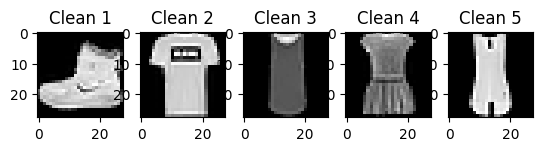

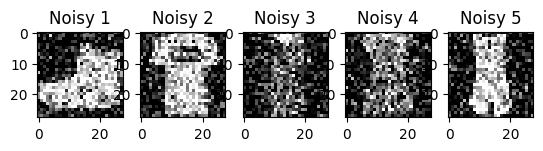

In [ ]:

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_clean_all[i].float().numpy().squeeze(), cmap='gray')
    plt.title(f'Clean {i+1}')
plt.show()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_noisy_all[i].float().numpy().squeeze(), cmap='gray')
    plt.title(f'Noisy {i+1}')
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Enkoder: (1, 28, 28) -> (256, 3, 3)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dekoder: (256, 3, 3) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            # (256, 3, 3) -> (128, 7, 7)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            #  (128, 7, 7) -> (64, 14, 14)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            #  (64, 14, 14) -> (1, 28, 28)
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


num_epochs = 5

# PĘTLA TRENINGOWA
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # PARY (zaszumiony_X, czysty_Y)
    for noisy_data, clean_data in train_loader_denoising:

        #  dane na GPU/CPU
        noisy_data = noisy_data.to(device)
        clean_data = clean_data.to(device)

        optimizer.zero_grad()

        outputs = model(noisy_data)
        # Porównanie ODCZUMIONEGO WYJŚCIA (outputs) z CZYSTYM CELEM (clean_data)
        loss = criterion(outputs, clean_data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_denoising)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), 'autoencoder.pth')

Epoch [1/5], Loss: 0.0198
Epoch [2/5], Loss: 0.0115
Epoch [3/5], Loss: 0.0103
Epoch [4/5], Loss: 0.0096
Epoch [5/5], Loss: 0.0092


Real Test Images


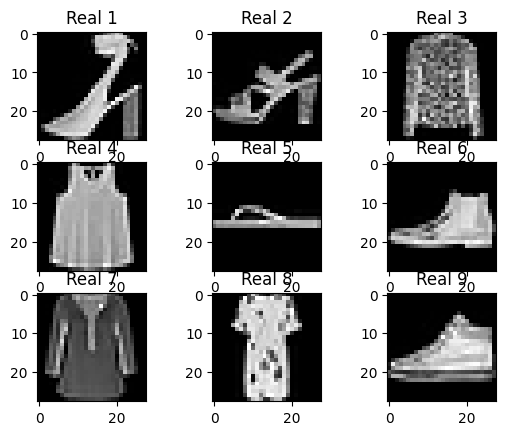

Noisy Test Images


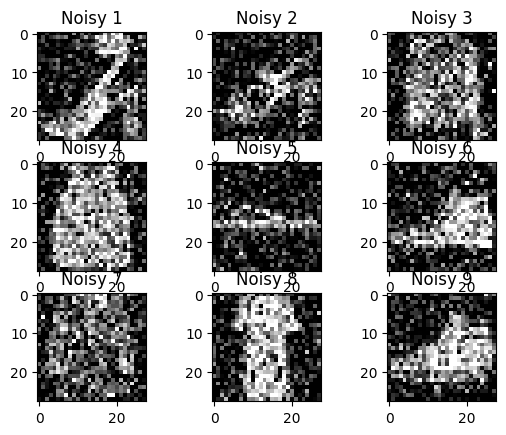

Cleaned Version


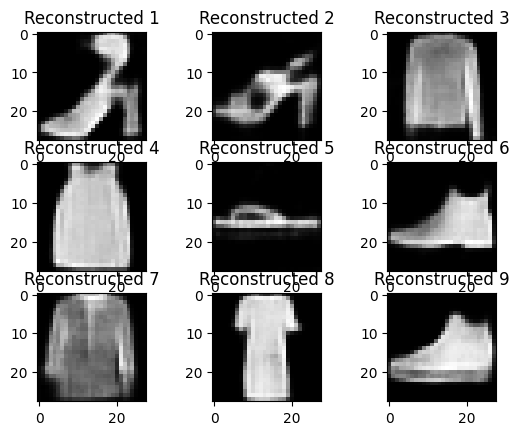

In [ ]:
offset = 1002


print("Real Test Images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_clean_all[i + offset].squeeze().numpy(), cmap='gray')
    plt.title(f'Real {i+1}')
plt.show()

print("Noisy Test Images")
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_noisy_all[i + offset].squeeze().numpy(), cmap='gray')
    plt.title(f'Noisy {i+1}')
plt.show()


print("Cleaned Version")
model.eval()
with torch.no_grad():
    for i in range(9):
        plt.subplot(330 + 1 + i)


        noisy_image = test_noisy_all[i + offset].unsqueeze(0).to(device)


        output = model(noisy_image)

        op_image = output[0].cpu().squeeze().numpy()

        plt.imshow(op_image, cmap='gray')
        plt.title(f'Reconstructed {i+1}')
plt.show()